In [1]:
!pip install -U spaCy
!pip install keras
!python -m spacy download it_core_news_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-05-07 17:29:06.974366: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 17:29:09.126951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.9/567.9 MB 2.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_lg')


# Text Categorization

The goal is to classify documents according to a set of predefined classes (labels).

We need training data for training a supervised approaches.

The process for training a classifier:
1. Load training data
2. Data pre-processing
3. Create and extract features
4. Training a model 

For testing:
1. Load test data
2. Generate feature using the same approach adopted during the training
3. Classify test instances
4. Compute metrics

We use spaCy for text processing and scikit-learn for machine learning.

We define some functions for text processing.
We build also a class for implementing a custom Trasformer based on spaCy. This trasform will process the text.

In [39]:
import string
import spacy
import json
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy.lang.it.stop_words import STOP_WORDS
from spacy.lang.it import Italian
from sklearn import metrics
from sklearn import svm
from sklearn import neural_network
from sklearn import ensemble

#init spaCy
punctuations = string.punctuation
nlp = spacy.load("it_core_news_lg")
stop_words = spacy.lang.it.stop_words.STOP_WORDS
parser = Italian()

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

# Tokenizer function
def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.text for word in mytokens ]
    # remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens

Training data loading and features extraction.
We exploit BoW with the TfIdf as features.

In [40]:
df = open('dataset_05.json','r')
X = []
y = []

for line in df:
  j = json.loads(line)
  # the features: title, desc, text
  #X.append(j['title'])
  X.append(j['title']+' '+j['desc'])
  #X.append(j['title']+' '+j['desc']+' '+(j['text'] if 'text' in j  else '')) 
  y.append(j['topic']) # the labels

#BoW with word count
#vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
#BoW with TF-IDF
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

print(X[0])
print(y[0])

Politica. Miccoli (Pd): Una coalizione sociale per Cosenza e battere la destra - Reggio TV Politica. Miccoli (Pd): Una coalizione sociale per Cosenza e battere la destra  Reggio TV
politica


Split in train and test data.

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Build the model.

In [42]:
# Linear Support Vector Machine classifier
classifier = svm.LinearSVC()
# Multi-layer Perceptron classifier
#classifier = neural_network.MLPClassifier(hidden_layer_sizes=(512,),verbose=True,max_iter=40)
# Random Foreset
#classifier = ensemble.RandomForestClassifier()
# Create the pipeline
pipe = Pipeline([("cleaner", predictors()),
('vectorizer', vector),
('classifier', classifier)])
# Fit the model
pipe.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f061082cd30>),
                ('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x7f06159f37f0>)),
                ('classifier', LinearSVC())])

Compute predictions on the test set and calculate metrics.

In [43]:
predicted = pipe.predict(X_test)
acc = metrics.accuracy_score(y_test, predicted)
print("Accuracy:", acc)
print("======================================================")
precision_macro = metrics.precision_score(y_test, predicted, average='macro')
recall_macro = metrics.recall_score(y_test, predicted, average='macro')
fm_macro = metrics.f1_score(y_test, predicted, average='macro')
print("P-macro={0}, R-macro={1}, F1-macro={2}".format(precision_macro, recall_macro, fm_macro))
print("======================================================")
precision_micro = metrics.precision_score(y_test, predicted, average='micro')
recall_micro = metrics.recall_score(y_test, predicted, average='micro')
fm_micro = metrics.f1_score(y_test, predicted, average='micro')
print("P-micro={0}, R-micro={1}, F1-micro={2}".format(precision_micro, recall_micro, fm_micro))
print("======================================================")
print(metrics.classification_report(y_test, predicted, digits=4))

Accuracy: 0.8019201616978272
P-macro=0.7793342188783638, R-macro=0.7411659898257534, F1-macro=0.7556045271964779
P-micro=0.8019201616978272, R-micro=0.8019201616978272, F1-micro=0.8019201616978272
                  precision    recall  f1-score   support

        ambiente     0.7470    0.6667    0.7045        93
animali e natura     0.5357    0.4455    0.4865       101
     cinema e tv     0.7736    0.7736    0.7736        53
         cronaca     0.7182    0.8952    0.7970       353
         cultura     0.9357    0.9091    0.9222       176
        economia     0.8556    0.8556    0.8556       180
          estero     0.6444    0.6905    0.6667        84
          motori     0.8989    0.8081    0.8511        99
        politica     0.8869    0.8765    0.8817       170
          salute     0.6349    0.5797    0.6061        69
         scienza     0.6897    0.3922    0.5000        51
      spettecolo     0.7589    0.7870    0.7727       108
           sport     0.8944    0.8571    0.8754 

Build the confusion matrix.

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predicted)
print(cm)

[[ 62   9   0   7   1   3   1   1   1   2   1   5   0   0]
 [  7  45   0  14   1   1   3   0   0  21   3   4   0   2]
 [  0   2  41   3   1   0   0   1   1   0   0   2   2   0]
 [  0   7   1 316   1   7   4   0   5   0   0   3   8   1]
 [  0   2   1   6 160   0   1   0   0   0   0   4   2   0]
 [  3   0   0  12   2 154   3   1   2   0   0   2   1   0]
 [  2   2   3   7   0   3  58   2   5   0   0   1   0   1]
 [  0   0   0   2   0   0   2  80   0   0   0   0  14   1]
 [  1   0   0  11   0   5   1   0 149   0   0   0   3   0]
 [  2   8   1   5   0   0   3   1   2  40   2   3   2   0]
 [  5   3   0   5   2   2   6   0   2   0  20   3   2   1]
 [  0   4   5   6   3   1   4   0   0   0   0  85   0   0]
 [  0   0   0  44   0   0   2   1   1   0   0   0 288   0]
 [  1   2   1   2   0   4   2   2   0   0   3   0   0  89]]


Visualize the confusion matrix.

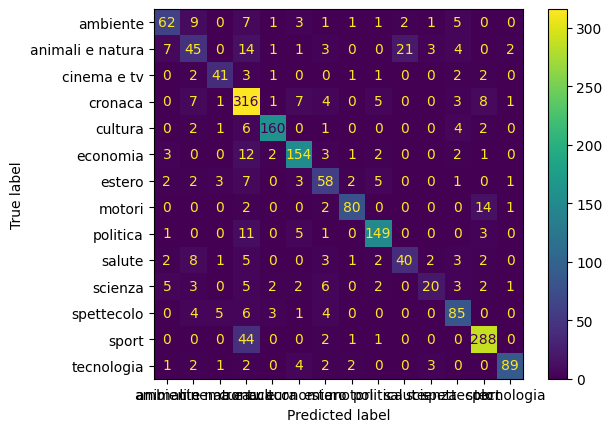

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

# Using embeddings for the classification

Each training document is represented as a vector obtained by averaging word embeddings.
We use embeddings provided by the spaCy Italian model.

In [46]:
df = open('dataset_05.json','r')
X = []
y = []
for line in df:
  j = json.loads(line)
  #text = j['title']
  text = j['title']+' '+j['desc']
  #text = j['title']+' '+j['desc']+' '+(j['text'] if 'text' in j  else '')
  doc = nlp(text)
  X.append(doc.vector) # the document embedding
  y.append(j['topic']) # the labels

print(X[0])
print(y[0])

KeyboardInterrupt: ignored

Execute train and test by using embeddings.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#classifier = svm.LinearSVC()
classifier = neural_network.MLPClassifier(hidden_layer_sizes=(512,),verbose=True,max_iter=40)
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
acc = metrics.accuracy_score(y_test, predicted)
print("Accuracy:", acc)
print("======================================================")
precision_macro = metrics.precision_score(y_test, predicted, average='macro')
recall_macro = metrics.recall_score(y_test, predicted, average='macro')
fm_macro = metrics.f1_score(y_test, predicted, average='macro')
print("P-macro={0}, R-macro={1}, F1-macro={2}".format(precision_macro, recall_macro, fm_macro))
print("======================================================")
precision_micro = metrics.precision_score(y_test, predicted, average='micro')
recall_micro = metrics.recall_score(y_test, predicted, average='micro')
fm_micro = metrics.f1_score(y_test, predicted, average='micro')
print("P-micro={0}, R-micro={1}, F1-micro={2}".format(precision_micro, recall_micro, fm_micro))
print("======================================================")
print(metrics.classification_report(y_test, predicted, digits=4))

Iteration 1, loss = 1.67443394
Iteration 2, loss = 1.01520304
Iteration 3, loss = 0.81744649
Iteration 4, loss = 0.70784801
Iteration 5, loss = 0.63947225
Iteration 6, loss = 0.57670817
Iteration 7, loss = 0.53684861
Iteration 8, loss = 0.48630592
Iteration 9, loss = 0.44066535
Iteration 10, loss = 0.40586160
Iteration 11, loss = 0.37147539
Iteration 12, loss = 0.33944970
Iteration 13, loss = 0.31668764
Iteration 14, loss = 0.28341355
Iteration 15, loss = 0.26287087
Iteration 16, loss = 0.23802399
Iteration 17, loss = 0.22266120
Iteration 18, loss = 0.20193504
Iteration 19, loss = 0.18066918
Iteration 20, loss = 0.16167067
Iteration 21, loss = 0.14399931
Iteration 22, loss = 0.12754439
Iteration 23, loss = 0.11857936
Iteration 24, loss = 0.11165140
Iteration 25, loss = 0.10106053
Iteration 26, loss = 0.09256816
Iteration 27, loss = 0.08446554
Iteration 28, loss = 0.07351907
Iteration 29, loss = 0.06691225
Iteration 30, loss = 0.05915408
Iteration 31, loss = 0.05865736
Iteration 32, los

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


# Text categorization using Deep Learning (with Keras)

Now you are finally ready to experiment with Deep Learning and Keras. Keras supports two main types of models. You have the Sequential model API which you are going to see in use in this tutorial and the functional API which can do everything of the Sequential model but it can be also used for advanced models with complex network architectures.

The Sequential model is a linear stack of layers, where you can use the large variety of available layers in Keras. The most common layer is the Dense layer which is your regular densely connected neural network layer.

We need to prepare training and testing data.

In [47]:
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import LabelBinarizer

df = open('dataset_05.json','r')
X_text = []
y = []
for line in df:
  j = json.loads(line)
  #text = j['title']
  text = j['title']+' '+j['desc']
  #text = j['title']+' '+j['desc']+' '+(j['text'] if 'text' in j  else '')
  X_text.append(text)
  y.append(j['topic']) # the labels

vectorizer = CountVectorizer()
vectorizer.fit(X_text)
X = vectorizer.transform(X_text)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Number of features
input_dim = X_train.shape[1]
print("Number of features: ",input_dim)

# binarize labels
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
nc = encoder.classes_.size
print("Number of classes: ",nc)

Number of features:  19326
Number of classes:  14


We design the network and compile it.

In [48]:
model = Sequential()
model.add(layers.Dense(256, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(128, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(nc, activation='softmax')) # nc is the number of classes

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4947712   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 14)                1806      
                                                                 
Total params: 4,982,414
Trainable params: 4,982,414
Non-trainable params: 0
_________________________________________________________________


Now, we can fit the network on training data. We use testing data for validation.
The fit function requires the number of epochs and the batch size.

In [49]:
from keras.backend import clear_session
clear_session() # Make sure to call clear_session() before you start training the model again
model.fit(X_train, y_train, epochs=5, verbose=True, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/5
248/248 [==============================] - 19s 73ms/step - loss: 1.0628 - accuracy: 0.6917 - val_loss: 0.6349 - val_accuracy: 0.8055
Epoch 2/5
248/248 [==============================] - 17s 70ms/step - loss: 0.1175 - accuracy: 0.9671 - val_loss: 0.6693 - val_accuracy: 0.8080
Epoch 3/5
248/248 [==============================] - 17s 69ms/step - loss: 0.0105 - accuracy: 0.9989 - val_loss: 0.6769 - val_accuracy: 0.8125
Epoch 4/5
248/248 [==============================] - 18s 71ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.6977 - val_accuracy: 0.8120
Epoch 5/5
248/248 [==============================] - 17s 69ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.7146 - val_accuracy: 0.8125


Compute accuracy on both training and test set.

In [50]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9996
Testing Accuracy:  0.8125


# Using word embeddings

We can directly use pretrained word embeddings in our model as input.

In [51]:
df = open('dataset_05.json','r')
X = []
y = []
for line in df:
  j = json.loads(line)
  #text = j['title']
  text = j['title']+' '+j['desc']
  #text = j['title']+' '+(j['text'] if 'text' in j  else '')
  X.append(text.lower())
  y.append(j['topic']) # the labels

Now we need to tokenize the data into a format that can be used by the word embeddings. Keras offers a couple of convenience methods for text preprocessing and sequence preprocessing which you can employ to prepare your text.

You can start by using the Tokenizer utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. You can add the parameter num_words, which is responsible for setting the size of the vocabulary. The most common num_words words will be then kept.

In [52]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size:',vocab_size)

Vocabulary size: 21785


One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

Additionally you would want to add a maxlen parameter to specify how long the sequences should be. This cuts sequences that exceed that number. In the following code, you can see how to pad sequences with Keras:

In [53]:
from keras.utils import pad_sequences

maxlen = 128

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0])

[1694  152  130   77 1621 1479   33   17    8 1694  152  130   77 1621
 1479   33   17    8    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


We need to binarize the labels.

In [54]:
# binarize labels
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
nc = encoder.classes_.size
print('Number of classes:',nc)

Number of classes: 14


You can see in the next example how you can load the embedding matrix. Each line in the file starts with the word and is followed by the embedding vector for the particular word.

This is a large file with each line representing a word followed by its vector as a stream of floats.

Since you don’t need all words, you can focus on only the words that we have in our vocabulary. Since we have only a limited number of words in our vocabulary.


In [55]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        f.readline # skip first line that contains word space info
        for line in f:
            word, *vector = line.split()
            if word in word_index: # load only word embeddings into the vocabulary
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

Download pre-trained word embeddings for Italian from fasttext.

In [30]:
!wget 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.it.300.vec.gz'
!gunzip cc.it.300.vec.gz

--2023-05-07 17:51:32--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.it.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.162.35, 108.157.162.120, 108.157.162.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.162.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272825284 (1.2G) [binary/octet-stream]
Saving to: ‘cc.it.300.vec.gz’

cc.it.300.vec.gz    100%[===================>]   1.18G  43.8MB/s    in 26s     

2023-05-07 17:51:58 (47.0 MB/s) - ‘cc.it.300.vec.gz’ saved [1272825284/1272825284]



You can use this function now to retrieve the embedding matrix.
We use word embeddings from fasttext.

In [56]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix('cc.it.300.vec', tokenizer.word_index, embedding_dim)

Vocabulary coverage.

In [57]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Vocabulary coverage: ',nonzero_elements / vocab_size)

Vocabulary coverage:  0.7539132430571495


We now design the new model with the word embeddings and the GlobalMaxPool layers.

In [58]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(nc, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 300)          6535500   
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1024)              308224    
                                                                 
 dense_1 (Dense)             (None, 14)                14350     
                                                                 
Total params: 6,858,074
Trainable params: 322,574
Non-trainable params: 6,535,500
_________________________________________________________________


Fit the model.

In [59]:
clear_session()
model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=32)

Epoch 1/10
248/248 [==============================] - 3s 10ms/step - loss: 2.2630 - accuracy: 0.2899 - val_loss: 2.1129 - val_accuracy: 0.3446
Epoch 2/10
248/248 [==============================] - 3s 10ms/step - loss: 1.9889 - accuracy: 0.3767 - val_loss: 2.0042 - val_accuracy: 0.3699
Epoch 3/10
248/248 [==============================] - 3s 11ms/step - loss: 1.8330 - accuracy: 0.4246 - val_loss: 1.8225 - val_accuracy: 0.4330
Epoch 4/10
248/248 [==============================] - 2s 9ms/step - loss: 1.7273 - accuracy: 0.4580 - val_loss: 1.7913 - val_accuracy: 0.4356
Epoch 5/10
248/248 [==============================] - 2s 9ms/step - loss: 1.6614 - accuracy: 0.4760 - val_loss: 1.7795 - val_accuracy: 0.4310
Epoch 6/10
248/248 [==============================] - 2s 9ms/step - loss: 1.6186 - accuracy: 0.4920 - val_loss: 1.7038 - val_accuracy: 0.4785
Epoch 7/10
248/248 [==============================] - 2s 9ms/step - loss: 1.5580 - accuracy: 0.5094 - val_loss: 1.7136 - val_accuracy: 0.4785
Epo

In [61]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5584
Testing Accuracy:  0.4901


# Convolutional Neural Networks (CNN)

Convolutional neural networks or also called convnets.

They have revolutionized image classification and computer vision by being able to extract features from images and using them in neural networks. The properties that made them useful in image processing makes them also handy for sequence processing. You can imagine a CNN as a specialized neural network that is able to detect specific patterns.

If it is just another neural network, what differentiates it from what you have previously learned?

A CNN has hidden layers which are called convolutional layers. When you think of images, a computer has to deal with a two dimensional matrix of numbers and therefore you need some way to detect features in this matrix. These convolutional layers are able to detect edges, corners and other kinds of textures which makes them such a special tool. The convolutional layer consists of multiple filters which are slid across the image and are able to detect specific features.

This is the very core of the technique, the mathematical process of convolution. With each convolutional layer the network is able to detect more complex patterns.

When you are working with sequential data, like text, you work with one dimensional convolutions, but the idea and the application stays the same. You still want to pick up on patterns in the sequence which become more complex with each added convolutional layer.

Now let’s have a look how you can use this network in Keras. Keras offers again various Convolutional layers which you can use for this task. The layer you’ll need is the Conv1D layer. This layer has again various parameters to choose from. The ones you are interested in for now are the number of filters, the kernel size, and the activation function. You can add this layer in between the Embedding layer and the GlobalMaxPool1D layer:

In [62]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(512, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(nc, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 300)          6535500   
                                                                 
 conv1d (Conv1D)             (None, 124, 512)          768512    
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 14)                7182      
                                                                 
Total params: 7,573,850
Trainable params: 7,573,850
Non-trainable params: 0
______________________________________________

In [63]:
clear_session()
model.fit(X_train, y_train,
                    epochs=4,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)

Epoch 1/4
124/124 [==============================] - 148s 1s/step - loss: 1.4172 - accuracy: 0.5685 - val_loss: 0.8140 - val_accuracy: 0.7625
Epoch 2/4
124/124 [==============================] - 146s 1s/step - loss: 0.4471 - accuracy: 0.8724 - val_loss: 0.6696 - val_accuracy: 0.7979
Epoch 3/4
124/124 [==============================] - 140s 1s/step - loss: 0.0993 - accuracy: 0.9752 - val_loss: 0.7947 - val_accuracy: 0.7948
Epoch 4/4
124/124 [==============================] - 141s 1s/step - loss: 0.0128 - accuracy: 0.9977 - val_loss: 0.8143 - val_accuracy: 0.8014


In [64]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9995
Testing Accuracy:  0.8014
